# `popclass` Tutorial

This notebook is meant to be a way to field-test `popclass`.
Treat this as an interactable sandbox/tutorial to test on real data.

In [29]:
# imports
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, "..",)
from popclass.model import PopulationModel
from popclass.posterior import Posterior, InferenceData
from popclass.visualization import plot_population_model
from popclass.classify import classify

## Data

This example uses data from [Golovich et al. (2021)](https://iopscience.iop.org/article/10.3847/1538-4365/ac5969#https://gdo-microlensing.llnl.gov/).
We start by selecting  and reading in the data from a microlensing event [here](https://gdo-microlensing.llnl.gov/).

**If the link is down**:
Example data is included in `/data/parallax_trace.csv` within this parent directory.

In [30]:
example_posterior = pd.read_csv("data/parallax_trace.csv")
example_posterior['log10tE'] = np.log10(example_posterior['tE'])
example_posterior['log10piE'] = np.log10(example_posterior['piE'])

*If the link is not dead, a visualization from that set will be included here.*

##  Creating `popclass` Objects

To run the classifier, the user must create several objects that `popclass` understands:
1) A `Posterior` object that contains the set of posterior samples and parameter labels
2) An `InferenceData` object that includes the marginal of the parameters we may want for classification and associated prior density
3) A `PopulationModel` object

For this example, we are interested in classifiying in $\log_{10} t_E - \log_{10} \pi_E$ space.
We will first create a `Posterior` with the ful dataset, then a marginal over `log10tE` and `log10piE`. 

In [31]:
labels = ["log10tE", "log10piE"]

post = Posterior(
    samples=example_posterior.values,
    parameter_labels=example_posterior.columns
)

marginal = post.marginal(
    parameter_list=labels
)

Our marginal looks like: {{marginal}}.
If we want to use this for classification, we need to specify a prior density.
For this example, it will be defined somewhat arbitrarily.

In [32]:
prior_density = 0.28 * np.ones(len(example_posterior['log10piE']))

Create an `InferenceData` object.

In [33]:
inference_data = post.to_inference_data(
    prior_density=prior_density
)

The last ingredient for classification is the `PopulationModel`.
For this, we will use one of the models included in the library/

In [34]:
population_model = PopulationModel.from_library(
    "popsycle_singles_sukhboldn20",
    library_path="../popclass/data/"
)

We can also visualize the population model by using visualization tools included in the library.

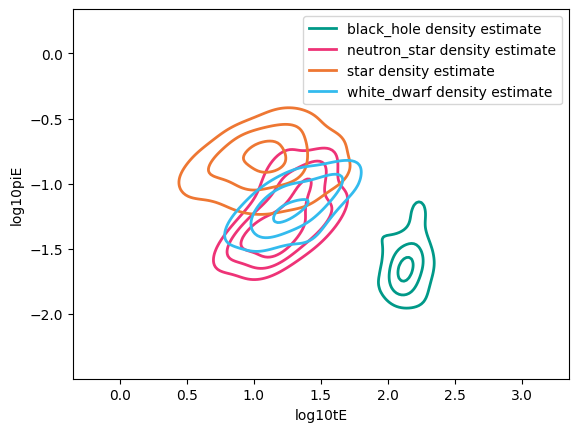

In [35]:
fig, ax = plot_population_model(
    PopulationModel=population_model,
    parameters=labels,
    levels=3,
    legend=True
)

## Running the classifier

With all of the ingredients in place, running the classifier is straightforward.
The output of the classifier is a dictionary containing `{classname: probability}` for each class.

In [36]:
classify(
    inference_data=inference_data,
    population_model=population_model,
    parameters=labels
)

{'black_hole': 1.798726897759209e-05,
 'neutron_star': 0.021494370999817332,
 'star': 0.799338599230312,
 'white_dwarf': 0.17914904250089306}

From the results of the classifier, our example event is *most* likely a star.